# Building a GCN from Scratch

<a href="https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Basic_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, setting up our environment.

In [18]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib

In [19]:
%matplotlib inline

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Let us built a toy GCN from scratch (inspired by https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)

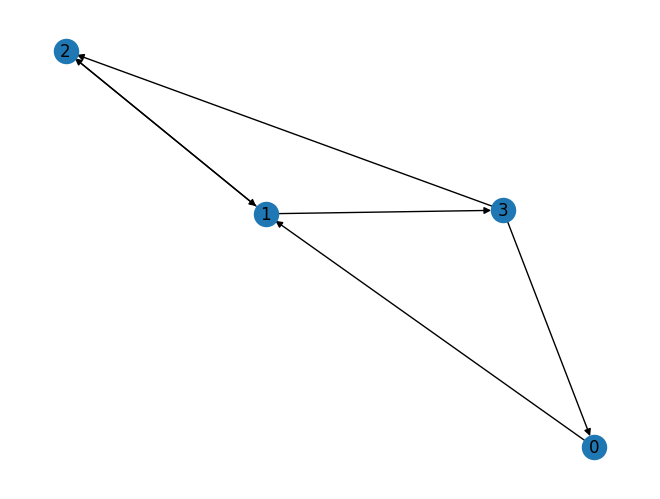

In [4]:
#Graph expressed by the adjacency matrix
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)

# Draw the graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph())
nx.draw(G, with_labels=True)

Next, we need to add some features to the edges. For simplicity we will use two floats (+/- the node's id).

In [6]:
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)

X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

A GCN hidden layer can be seen Hⁱ = f(Hⁱ⁻¹, A)) where A is the adjacency matrix of the graph, Hⁱ⁻¹ is the previous layer (and hence H⁰ = X = feature vector). f() is our respective propagation function specifying how features are aggregated.
The most basic function imaginable would be f(X, A) = AX (not too meaningful, but helpful to understand the concept).

In [7]:
h_1 = A * X
print(h_1)

[[ 1. -1.]
 [ 5. -5.]
 [ 1. -1.]
 [ 2. -2.]]


So every node feature is now the sum if its direct neighbours. Note that we are working with a directed graphs and the a directed edge from 0 to 1 indicated that 1 is a neighbour of 0 but note vice versa (so the messages flow opposite to the arrows in the above visualization).

This would represent a GCN with just a single layer and means the features in the output are only influenced by the direct neighbours and not even the node value itself, but we fix that next.

[[ 1. -1.]
 [ 6. -6.]
 [ 3. -3.]
 [ 5. -5.]]
[[1. 1. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 0.]
 [1. 0. 1. 1.]]


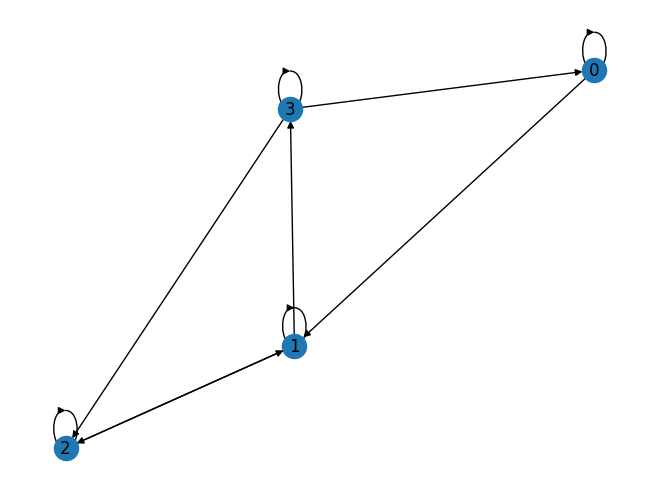

In [10]:
# We can simply extend our adjacency matrix with a self-loop to preserve the current node value
I = np.matrix(np.eye(A.shape[0]))
A_hat = A + I

h1_hat = A_hat * X
print(h1_hat)

print(A_hat)

# Draw the graph
G1 = nx.from_numpy_array(A_hat, create_using=nx.DiGraph())
nx.draw(G1, with_labels=True)

Still nodes with more neighbours will accumulate higher values, but we can use the degree (i.e., number of neighbours) to normalize.

In [11]:
# First compute the degree matrix of A
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
print(D)
print()

# Also compute the degree matrix of A_hat
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
print(D_hat)
print()

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]

[[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]



In [12]:
# Next we use that to normalize our A_hat
A_hat_2 = D_hat**-1 * A_hat

h_hat_2 = A_hat_2 * X
print(h_hat_2)
print()

print("Just to recall the degree of each node (including the self loop):")
print(np.diag(D_hat))

[[ 0.5 -0.5]
 [ 2.  -2. ]
 [ 1.  -1. ]
 [ 2.5 -2.5]]

Just to recall the degree of each node (including the self loop):
[2. 3. 3. 2.]


Note that compared to h1_hat the values have been divided by the degree of each node.

Our current propagation function f(X, A) = A_hat_2 * X is static and there are no parameters we could learn.
Let us add weights f(Hⁱ, A) = AHⁱWⁱ and hence allow for our network to be trainable.

In [13]:
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])

h_hat_3 = A_hat_2 * X * W
(print(h_hat_3))

[[ 1. -1.]
 [ 4. -4.]
 [ 2. -2.]
 [ 5. -5.]]


The last missing piece is to add a non-linear activiation function: f(Hⁱ, A) = σ(AHⁱWⁱ)

In [14]:
def relu(X):
   return np.maximum(0,X)

h_hat_4 = relu(A_hat_2 * X * W)
(print(h_hat_4))

[[1. 0.]
 [4. 0.]
 [2. 0.]
 [5. 0.]]


Congratulation, you have built a GCN hidden layer with adjacency matrix, features, weights and a relu activation function from scratch!

# Back to the Karate Club!

![karate](https://github.com/joerg84/Graph_Powered_ML_Workshop/blob/master/img/karate_club.png?raw=1)

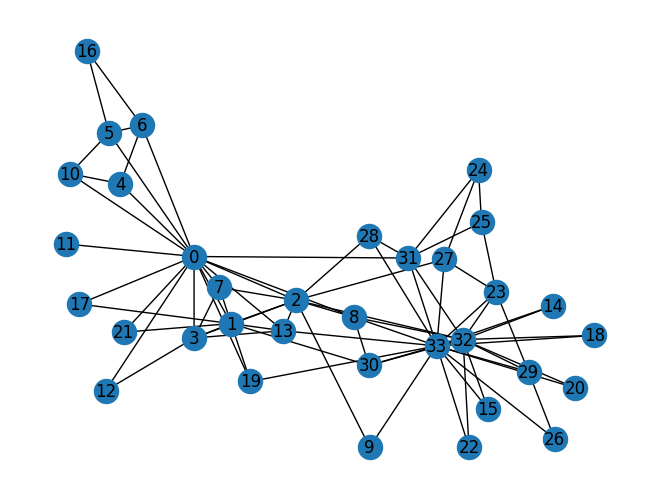

In [21]:
# We use the karate club representation from networkx
zkc = nx.karate_club_graph()
order = sorted(list(zkc.nodes()))

nx.draw(zkc, with_labels=True)

Let us extract the adjacency matrix:

In [22]:
A = nx.to_numpy_array(zkc, nodelist=order)
print(A)

[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]


In [23]:
# As before add self-loops
num_nodes = A.shape[0]
I = np.matrix(np.eye(num_nodes))
A_hat = A + I

# And create degree matrix
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

print(D_hat)

[[43.  0.  0. ...  0.  0.  0.]
 [ 0. 30.  0. ...  0.  0.  0.]
 [ 0.  0. 34. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 22.  0.  0.]
 [ 0.  0.  0. ...  0. 39.  0.]
 [ 0.  0.  0. ...  0.  0. 49.]]


As we will learn them later, let us initialize the weights randomly:

In [24]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(num_nodes, 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

print(W_1)

[[ 1.20160415  2.19183942  1.86187184  0.70480554]
 [ 0.02544993  1.52875213 -0.36892025 -0.08063622]
 [ 1.12034445 -1.96410243  0.68625984 -0.93748656]
 [-0.92278567 -1.30876288 -0.07302196  0.49416149]
 [-1.93821767  0.76637255  0.31137281  0.29139418]
 [ 1.49784894 -0.25734982  1.16745239  0.79365257]
 [-1.40500583  1.53247599  0.92668584 -1.74610274]
 [-1.74313395  0.68592835  0.01083662  0.05917822]
 [-1.74429339  0.65795485  0.88474291  0.49135223]
 [ 1.085947    0.66481585  0.75112082 -2.44990244]
 [-0.72776716  0.16359599 -1.23795326  0.79957451]
 [ 0.7596598  -0.90163234  0.4806329  -0.51784835]
 [ 0.95289175  0.49048513  0.4044712   0.80059155]
 [ 0.71935582  1.13674259 -0.18650332 -0.2488005 ]
 [ 1.61160112  1.25970923 -1.79576275  1.01415797]
 [ 0.26938412 -0.75218905 -1.94047402  0.50392339]
 [ 1.45320145 -1.4022419   0.55727012  1.7282838 ]
 [ 0.96770851  0.45387142  0.01138304 -1.75859886]
 [-1.03366172 -2.33223499 -1.45554233  0.57866819]
 [ 0.60787821  1.24086917 -0.61

For readability we create a helper function for the hidden layers:

In [25]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

With that we are ready to specify a two layer GCN:

In [26]:
# As input we use the identity matrix, i.e., each node is represented as a one-hot encoded categorical variable.
H_0 = np.matrix(np.eye(num_nodes))

H_1 = gcn_layer(A_hat, D_hat, H_0, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)

output = H_2
print(output)

[[0.         0.87805922]
 [0.         0.78755789]
 [0.         0.15742015]
 [0.         0.29218771]
 [0.         0.58866336]
 [0.         0.36499108]
 [0.         0.67560534]
 [0.         0.52048616]
 [0.         0.4948856 ]
 [0.         0.20968425]
 [0.         1.05388015]
 [0.         0.50693655]
 [0.         0.47796928]
 [0.         0.40316358]
 [0.         0.20318506]
 [0.         0.06802199]
 [0.         0.49309066]
 [0.         0.65518964]
 [0.         0.        ]
 [0.         0.48924833]
 [0.         0.19539648]
 [0.         0.5354152 ]
 [0.         0.11432972]
 [0.         0.04517228]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.15366066]
 [0.         0.        ]
 [0.         0.27279813]
 [0.         0.        ]
 [0.         0.13809744]
 [0.         0.01093032]
 [0.         0.3826651 ]
 [0.         0.25855803]]


Let us look at the output (keeping in mind we haven't trained the network yet and the weights are random!)

In [27]:
for node in range(34):
    print(node)
    print(output[node])
    print()

0
[[0.         0.87805922]]

1
[[0.         0.78755789]]

2
[[0.         0.15742015]]

3
[[0.         0.29218771]]

4
[[0.         0.58866336]]

5
[[0.         0.36499108]]

6
[[0.         0.67560534]]

7
[[0.         0.52048616]]

8
[[0.        0.4948856]]

9
[[0.         0.20968425]]

10
[[0.         1.05388015]]

11
[[0.         0.50693655]]

12
[[0.         0.47796928]]

13
[[0.         0.40316358]]

14
[[0.         0.20318506]]

15
[[0.         0.06802199]]

16
[[0.         0.49309066]]

17
[[0.         0.65518964]]

18
[[0. 0.]]

19
[[0.         0.48924833]]

20
[[0.         0.19539648]]

21
[[0.        0.5354152]]

22
[[0.         0.11432972]]

23
[[0.         0.04517228]]

24
[[0. 0.]]

25
[[0. 0.]]

26
[[0.         0.15366066]]

27
[[0. 0.]]

28
[[0.         0.27279813]]

29
[[0. 0.]]

30
[[0.         0.13809744]]

31
[[0.         0.01093032]]

32
[[0.        0.3826651]]

33
[[0.         0.25855803]]



In the next notebook we will actually train a GCN.